# Logist Regression Approach (Sign Language Digits Dataset)
    
## Introduction

This notebook is a simple approach to the Sign Language Digits Dataset using Logistic Regression. The dataset consists of 2062 64x64 images of hand signs representing numbers from 0 to 9. The goal is to classify the images into the correct number using logistic regression. We will use the accuracy score as the metric to evaluate the model pair with the confusion matrix, F1 score, precision and recall. We will also test with PCA to see if it improves the model.



## Libraries

We will use the following libraries:

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import os
import seaborn as sns
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import train_test_split


## Data Loading

Load the data, which consists of features (X) and labels (Y), from `.npy` files.

In [23]:
X_original = np.load('archive/X.npy')
Y_original = np.load('archive/Y.npy')

## Organização dos Dados (NAO CORRER MAIS DO QUE UMA VEZ)


In [24]:
def save_dataset_with_timestamp(X, Y, prefix='archive/X', suffix='archive/Y'):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    np.save(f'{prefix}_{timestamp}.npy', X)
    np.save(f'{suffix}_{timestamp}.npy', Y)

X = np.copy(X_original)
Y = np.copy(Y_original)

# Mapping classes to the correct digits
# class 0 = digit 9, class 1 = digit 0, class 2 = digit 7, class 3 = digit 6, class 4 = digit 1, class 5 = digit 8, class 6 = digit 4, class 7 = digit 3, class 8 = digit 2, class 9 = digit 5

class_to_digit = {0: 9, 1: 0, 2: 7, 3: 6, 4: 1, 5: 8, 6: 4, 7: 3, 8: 2, 9: 5}

# Convert Y from one-hot encoding to class indices
labels_indices = np.argmax(Y, axis=1)

# Correct the indices based on the mapping
correted_labels = np.array([class_to_digit[label] for label in labels_indices])

# Convert back to one-hot encoding
correted_Y = np.eye(10)[correted_labels]

print('Labels corrigidos: ', correted_labels[:2000])

# Sort the dataset by the digit each sample represents
sorted_indices = np.argsort(correted_labels)

print('Labels ordenados: ', correted_labels[sorted_indices])


# ordenar os labels
correted_Y = correted_Y[sorted_indices]
correted_X = X[sorted_indices]

# salvar os dados
save_dataset_with_timestamp(correted_X, correted_Y)


Labels corrigidos:  [9 9 9 ... 5 5 5]
Labels ordenados:  [0 0 0 ... 9 9 9]


## Sample Distribution Analysis

To understand the balance between different classes in our dataset, it's useful to visualize the distribution of samples across classes. This helps in identifying if there's a class imbalance that might affect model training.

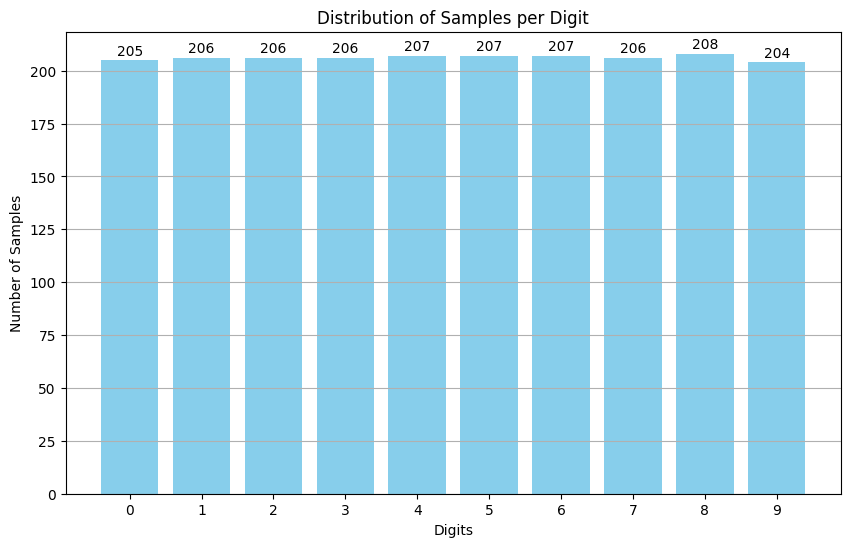

In [25]:
# Count the number of samples per digit
samples_per_digit = np.bincount(correted_labels[sorted_indices])

# Unique classes (assuming classes are sequential and start from 0)
unique_classes = np.arange(len(samples_per_digit))

#Print the number of samples per class
# print('Number of samples per class:')
# for i in range(len(samples_per_digit)):
#     print(f'Class {i}: {samples_per_digit[i]} samples')

# Create a histogram to visualize the distribution of samples per class
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, samples_per_digit, color='skyblue')
for i in range(len(samples_per_digit)):
    plt.text(i, samples_per_digit[i] + 1, str(samples_per_digit[i]), ha='center', va='bottom')
plt.xlabel('Digits')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples per Digit')
plt.xticks(unique_classes)
plt.grid(axis='y')

plt.show()

## Splitting the Data

We will split the data into training and testing sets using the `train_test_split` function from the `sklearn` library.

In [26]:
# # We are going to create a training,test and validation array, 70% - training, 15% - test, 15% - cross validation


# reshape dataset to 2D, removing the third dimension
X_flatten = correted_X.reshape(correted_X.shape[0], correted_X.shape[1] * correted_X.shape[2])

# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_flatten, correted_Y, test_size=0.3, random_state=42)

# Split the test set into test and validation sets
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Print the shapes of the training, test and validation sets
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')

print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')

X_train shape: (1443, 4096)
Y_train shape: (1443, 10)
X_test shape: (309, 4096)
Y_test shape: (309, 10)
X_val shape: (310, 4096)
Y_val shape: (310, 10)


## Logistic Regression Approach (Classes Code)

### Sigmoid

In [27]:
def sigmoid(z):
    """
    return the sigmoid of z
    """

    gz = 1/(1 + np.exp(-z))
    
    return gz

### Cost Function Regularized

In [31]:
def costFunctionReg(X, y, theta, Lambda):
    m = len(y)
    h = sigmoid(X @ theta)  # Assume h is (1443, 10) for multiclass
    error = -y * np.log(h) - (1 - y) * np.log(1 - h)
    cost = (1 / m) * np.sum(error)
    regCost = cost + (Lambda / (2 * m)) * np.sum(theta[1:] ** 2)
    
    reg_term = np.zeros_like(theta)
    reg_term[1:] = (Lambda / m) * theta[1:]
    grad = (1 / m) * (X.T @ (h - y)) + reg_term

    return regCost, grad


### Gradient Descent

In [32]:
def gradientDescent(X, y, theta, alpha, num_iters, Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    Lambda is the regularization term
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        
        # call CostFunctionReg 
        cost, grad = costFunctionReg(X, y, theta, Lambda)
        
        # update theta
        theta = theta - (alpha * grad)
        
        J_history.append(cost)
    
    return theta , J_history

### Test Parameters

In [33]:
#Number of features
features = X_train.shape[1]

print('Number of features: ', features)
print('Number of classes: ', Y_train.shape[1])

# Test with different learning rates
learning_rates = [0.1, 0.01, 0.001]

theta = np.zeros((features, 1))

# Number of iterations
num_iters = 1000

print(X_train.shape)
print(Y_train.shape)
print(theta.shape)

#Lambda
Lambda = 0.1

theta , J_history = gradientDescent(X_train, Y_train, theta, learning_rates[0], num_iters, Lambda)


Number of features:  4096
Number of classes:  10
(1443, 4096)
(1443, 10)
(4096, 1)


### Running the gradient descent for Each leraning rates

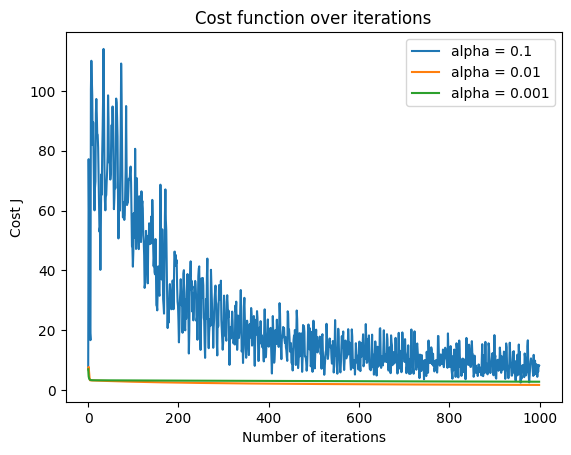

In [34]:
# Run gradient descent for each learning rate
for alpha in learning_rates:
    theta = np.zeros((features, 1))
    theta , J_history = gradientDescent(X_train, Y_train, theta, alpha, num_iters, Lambda)
    plt.plot(J_history, label=f'alpha = {alpha}')
    
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')
plt.title('Cost function over iterations')
plt.legend()
plt.show()